# 機器學習百日馬拉松期末考 - 貓狗圖像分類競賽

In [139]:
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten
# from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

import os
import numpy as np
from PIL import Image
from os.path import join
from matplotlib import pyplot as plt
import random
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### 讀取影像資料

In [140]:
from PIL import Image
from os.path import join

data_dir = "./data/kaggle_dogcat"
train_data_dir=join(data_dir, "train")

dog_dir = join(train_data_dir, "dogs")
cat_dir = join(train_data_dir, "cats")
dog_imgs = [f for f in os.listdir(dog_dir) if os.path.isfile(join(dog_dir, f))]
cat_imgs = [f for f in os.listdir(cat_dir) if os.path.isfile(join(cat_dir, f))]

print("Total dog image #={}".format(len(dog_imgs)))
print("Total cat image #={}".format(len(cat_imgs)))

Total dog image #=1500
Total cat image #=1500


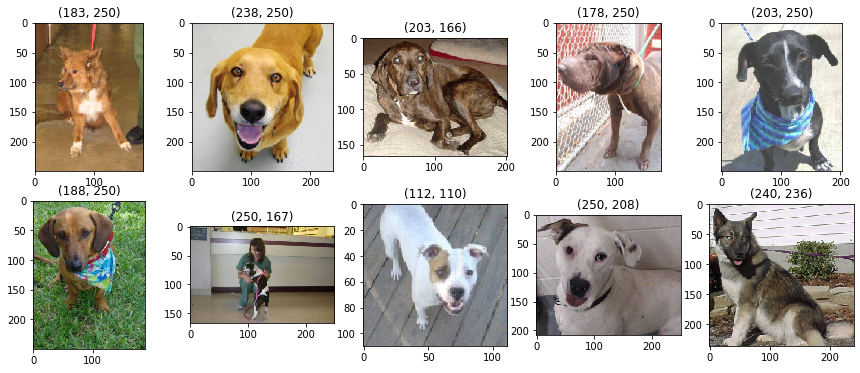

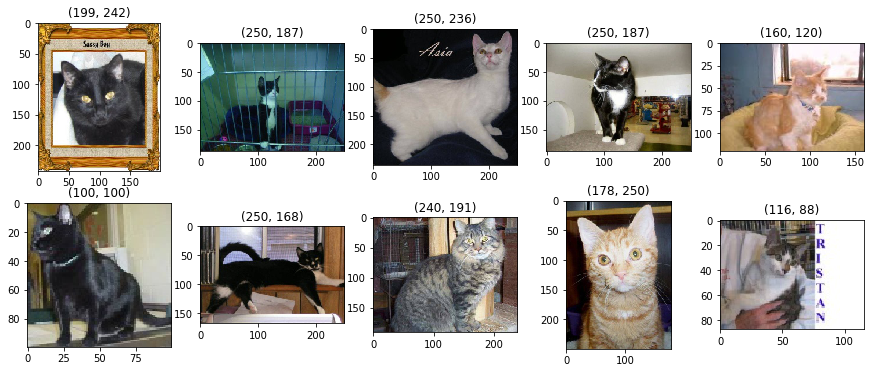

In [141]:
from PIL import Image
from matplotlib import pyplot as plt
import random

# show dog images 
def show_img(nrow, ncol, figsize, imgs, img_dir):
    plt.figure(figsize=figsize)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        img_file =imgs[random.randint(0,len(imgs))]
        img = Image.open(join(img_dir, img_file))
        plt.title(img.size)
        plt.imshow(img)
        
show_img(2,5, (15,6), dog_imgs, dog_dir)
show_img(2,5, (15,6), cat_imgs, cat_dir)

In [142]:
# cat, dog 兩類別
NUM_CLASSES = 2

# generator 每批次產生圖片數量
BATCH_SIZE = 128

FREEZE_LAYERS = 14

# 循環
EPOCHS = 50

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'net_final.h5'

WORKS = 3

# Target Image size
IMG_SIZE = (150,150)

# Train data dir
TRAIN_DATA_DIR = join(data_dir, "train")

# Validation data dir
VALIDATION_DATA_DIR = join(data_dir, "validation")

# 訓練圖片數量
TRAIN_DATA_SIZE = 1500

# 驗證圖片數量
VALIDATION_DATA_SIZE = 500

### 產生訓練資料

In [143]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')


for cls, idx in train_generator.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class #0 = cats
Class #1 = dogs


### 建立模型

In [145]:
# 建立 ResNet 模型
net = VGG16(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [146]:
net_final = Sequential()
for layer in net.layers:
    net_final.add(layer)    
net_final.add(Flatten())
net_final.add(Dropout(0.5))
net_final.add(Dense(256, activation='relu'))
net_final.add(Dense(NUM_CLASSES, activation='softmax', name='softmax'))
                       
# 設定凍結與要進行訓練的網路層
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

### 訓練模型

In [147]:
# 訓練模型
history = net_final.fit_generator(train_generator,
                        steps_per_epoch = TRAIN_DATA_SIZE//BATCH_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_DATA_SIZE//BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose=1,
                        workers=WORKS)

Epoch 1/50
11/11 [==============================] - 27s 2s/step - loss: 0.8144 - acc: 0.4901 - val_loss: 0.6387 - val_acc: 0.6562
Epoch 2/50
11/11 [==============================] - 9s 809ms/step - loss: 0.7125 - acc: 0.5589 - val_loss: 0.6292 - val_acc: 0.6719
Epoch 3/50
11/11 [==============================] - 8s 773ms/step - loss: 0.6787 - acc: 0.5857 - val_loss: 0.5448 - val_acc: 0.7778
Epoch 4/50
11/11 [==============================] - 9s 806ms/step - loss: 0.6618 - acc: 0.6207 - val_loss: 0.5435 - val_acc: 0.7682
Epoch 5/50
11/11 [==============================] - 9s 776ms/step - loss: 0.6084 - acc: 0.6712 - val_loss: 0.4190 - val_acc: 0.8464
Epoch 6/50
11/11 [==============================] - 9s 796ms/step - loss: 0.5726 - acc: 0.7038 - val_loss: 0.4253 - val_acc: 0.8250
Epoch 7/50
11/11 [==============================] - 9s 778ms/step - loss: 0.5107 - acc: 0.7571 - val_loss: 0.4204 - val_acc: 0.8151
Epoch 8/50
11/11 [==============================] - 9s 798ms/step - loss: 0.49

In [148]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Text(0, 0.5, 'Loss')

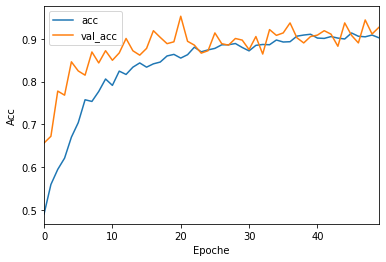

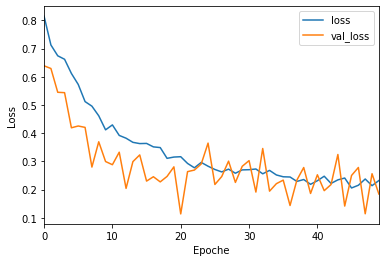

In [149]:
# 訓練歷程
import pandas as pd
%matplotlib inline

df = pd.DataFrame(history.history)
ax1 = df[["acc", "val_acc"]].plot()
ax1.set_xlabel("Epoche")
ax1.set_ylabel("Acc")

ax2 = df[["loss", "val_loss"]].plot()
ax2.set_xlabel("Epoche")
ax2.set_ylabel("Loss")

### 進行辨識

In [150]:
# Test data dir
TEST_DATA_DIR = join(data_dir, "test")

# 測試圖片數量
TEST_DATA_SIZE =400

# 預測結果
SUBMISSION=join(data_dir, "submission_pretrain.csv")

In [155]:
# 載入訓練好的模型
model = load_model(WEIGHTS_FINAL)
model.summary()

ValueError: You are trying to load a weight file containing 15 layers into a model with 0 layers

In [152]:
# 進行預測
# Class 0 = cats
# Class 1 = dogs

clss =["cat", "dog"]
test_files = [f for f in os.listdir(TEST_DATA_DIR) if os.path.isfile(join(TEST_DATA_DIR, f))]
cat_prob=[]
fid=[]
for f in test_files:
    img = Image.open(join(TEST_DATA_DIR, f)).resize(IMG_SIZE)
    x = np.asarray(img)
    x = np.expand_dims(x, axis = 0)
    pred_y = net_final.predict(x)[0]
    cat_prob.append(pred_y[0])
    fid.append(os.path.splitext(f)[0])
    idx = np.argmax(pred_y, axis=0)
    print("{} is {} {}".format(f, clss[idx] ,pred_y))
    
df = pd.DataFrame({"ID":fid, "Predicted":cat_prob})

053.jpg is cat [1. 0.]
067.jpg is cat [1.0000000e+00 2.3669084e-28]
215.jpg is dog [0. 1.]
255.jpg is dog [0. 1.]
378.jpg is dog [0. 1.]
315.jpg is dog [0. 1.]
129.jpg is dog [1.997351e-38 1.000000e+00]
233.jpg is dog [0. 1.]
008.jpg is cat [1. 0.]
258.jpg is cat [1. 0.]
159.jpg is cat [1. 0.]
225.jpg is dog [0. 1.]
050.jpg is cat [1. 0.]
256.jpg is cat [1. 0.]
081.jpg is dog [0. 1.]
246.jpg is cat [1. 0.]
220.jpg is dog [0. 1.]
023.jpg is cat [1. 0.]
112.jpg is cat [1. 0.]
145.jpg is dog [0. 1.]
251.jpg is cat [9.999993e-01 6.795186e-07]
018.jpg is dog [0. 1.]
049.jpg is cat [1.000000e+00 6.081181e-37]
196.jpg is dog [0. 1.]
350.jpg is dog [0. 1.]
141.jpg is cat [1. 0.]
190.jpg is dog [0. 1.]
189.jpg is cat [1. 0.]
209.jpg is cat [1. 0.]
347.jpg is dog [0. 1.]
334.jpg is dog [0. 1.]
326.jpg is cat [1. 0.]
354.jpg is dog [0. 1.]
270.jpg is cat [1. 0.]
319.jpg is cat [1. 0.]
247.jpg is dog [0. 1.]
059.jpg is cat [1. 0.]
311.jpg is dog [0. 1.]
199.jpg is dog [0. 1.]
280.jpg is cat [1. 0.

In [153]:
# 輸出預測結果
df.sort_values(by="ID").to_csv(SUBMISSION, index=False, float_format='%.15f')